## 1. Importaciones

In [1]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [3]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

    gsync = utils.GDriveSync()


try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

--2023-11-06 22:14:54--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2023-11-06 22:14:55 (46.2 MB/s) - ‘utils.py’ saved [4519/4519]

--2023-11-06 22:15:29--  https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StefOe/all-conv-pytorch/8545bb3ff7ac4410e52d8db930f0485074073ea9/allconv.py [following]
--2023-11-06 22:15:29--  https://raw.

## 2. Transformacion y carga de datos

In [11]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()

trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255


# Data normal (32x32)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_train8x8 = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


Files already downloaded and verified


In [16]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


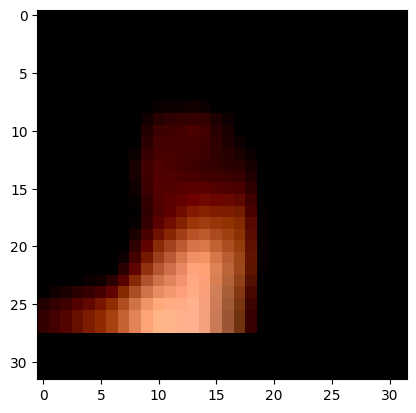

In [25]:
for batch_data, batch_labels in train_loader_blur:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

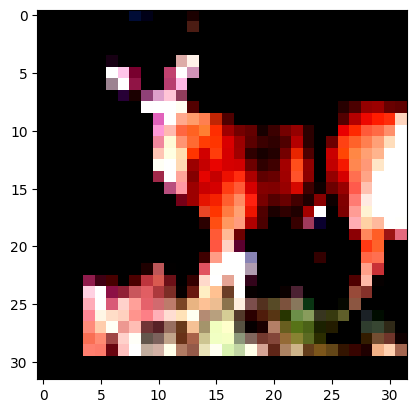

In [23]:
for batch_data, batch_labels in train_loader:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

## 3. Entrenamiento

In [26]:
model = AllConvNet(3)
if cuda:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[200, 250, 300], gamma=0.1)

In [27]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def blur_train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_blur):
        if cuda:
            data, target = data.cuda(), target.cuda() # Pasar la data a la GPU
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad() # Seteo en 0 los valores de los gradientes
        output = model(data) # Hago forward
        loss = criterion(output, target) # Se calcula la CrossEntropyLoss
        loss.backward()
        optimizer.step() # Actualización de los parámetros

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch, best_loss, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * correct /
            len(test_loader.dataset)))

    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss
        torch.save(model, "best.pt")
        if gsync_save:
            gsync.update_file_to_folder("best.pt")
    return best_loss, best_epoch

In [32]:
def begin_model(n_epochs: int, blur_epochs: int, blur_start: int):

  if n_epochs <  blur_epochs + blur_start:
    print('ERROR: parámetros inconsistentes')

  else:
    if blur_start == 0:

      for epoch in range(blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      for epoch in range(blur_start + blur_epochs, n_epochs):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)


    elif blur_start != 0:

      for epoch in range(blur_start):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      for epoch in range(blur_start, blur_start + blur_epochs):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      for epoch in range(blur_start + blur_epochs, n_epochs):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

In [ ]:
begin_model(n_epochs=40, blur_epochs=10, blur_start=10)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.303338
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.303931
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.300438
